In [1]:
import os
import random
import pathlib
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    TensorBoard, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
)


2025-10-04 02:22:39.184738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-04 02:22:39.252735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759524759.277852 3604790 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759524759.285376 3604790 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759524759.305432 3604790 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
data_dir_train = pathlib.Path("balanced/train/")
data_dir_test = pathlib.Path("balanced/test/")
data_dir_val = pathlib.Path("balanced/val/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

20700
4600


In [5]:
batch_size = 32
img_height = 224
img_width = 224
rnd_seed = 123
random.seed(rnd_seed)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20700 files belonging to 23 classes.


I0000 00:00:1759524777.355302 3604790 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20737 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:98:00.0, compute capability: 8.9
I0000 00:00:1759524777.358431 3604790 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20737 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:a8:00.0, compute capability: 8.9


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_val,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4600 files belonging to 23 classes.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4600 files belonging to 23 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


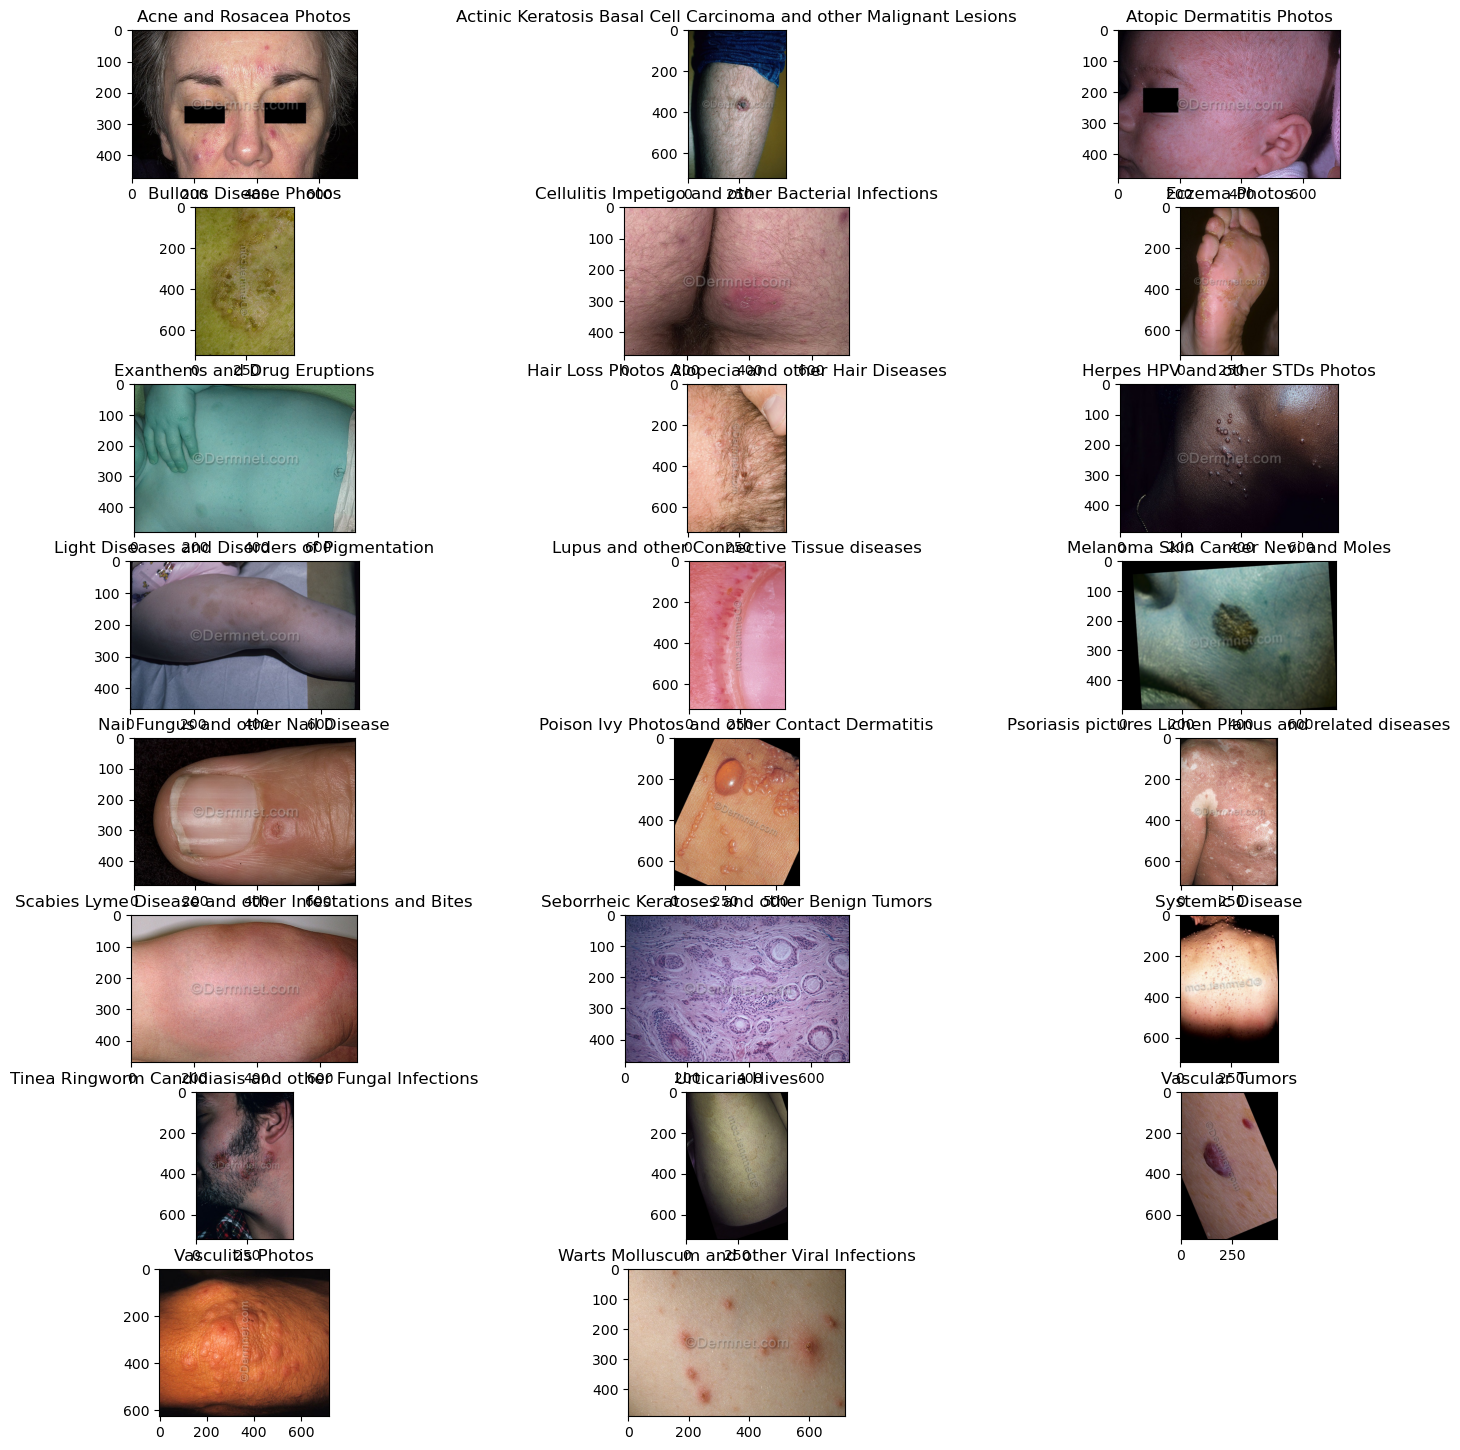

In [10]:
num_classes = len(class_names)
plt.figure(figsize=(18,18))
for i in range(num_classes):
  plt.subplot(8,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [11]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32,)


2025-10-04 02:23:04.603902: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model


num_classes=23
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the early layers of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

# Build a new model on top of the pre-trained base
inputs = base_model.input
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,500,183 (13.35 MB)

 Trainable params: 3,474,855 (13.26 MB)

 Non-trainable params: 25,328 (98.94 KB)

In [13]:
# Train the model
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


I0000 00:00:1759524801.317713 3605145 service.cc:152] XLA service 0x7c71b0004b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759524801.317763 3605145 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1759524801.317771 3605145 service.cc:160]   StreamExecutor device (1): NVIDIA L4, Compute Capability 8.9
2025-10-04 02:23:21.888216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759524805.125252 3605145 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-04 02:23:28.937321: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8617', 16 bytes spill stores, 16 bytes spill loads

2025-10-04 02:23:29.174546: I external/local_xla/xla/stream_executor/cuda/subprocess_compi

  3/647 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.0469 - loss: 3.6383   

I0000 00:00:1759524833.872942 3605145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


646/647 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4839 - loss: 1.8524 

2025-10-04 02:24:33.961271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8617', 5132 bytes spill stores, 5132 bytes spill loads

2025-10-04 02:24:34.375379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8617', 484 bytes spill stores, 484 bytes spill loads

2025-10-04 02:24:34.411191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8617_0', 20 bytes spill stores, 20 bytes spill loads

2025-10-04 02:24:34.478892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15370', 4 bytes spill stores, 4 bytes spill loads

2025-10-04 02:24:34.517676: I ext

647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4840 - loss: 1.8521

2025-10-04 02:25:00.008444: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1548', 8 bytes spill stores, 8 bytes spill loads

2025-10-04 02:25:00.172059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1548', 48 bytes spill stores, 48 bytes spill loads

2025-10-04 02:25:00.245078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1548', 264 bytes spill stores, 264 bytes spill loads

2025-10-04 02:25:00.631797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1548', 3492 bytes spill stores, 3492 bytes spill loads

2025-10-04 02:25:09.587268: I extern

647/647 ━━━━━━━━━━━━━━━━━━━━ 129s 128ms/step - accuracy: 0.5339 - loss: 1.6439 - val_accuracy: 0.0761 - val_loss: 35.5041
Epoch 2/50
647/647 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.6114 - loss: 1.3344 - val_accuracy: 0.0972 - val_loss: 28.1744
Epoch 3/50
647/647 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.6462 - loss: 1.2010 - val_accuracy: 0.2561 - val_loss: 2.9793
Epoch 4/50
647/647 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.7011 - loss: 0.9986 - val_accuracy: 0.2667 - val_loss: 2.6918
Epoch 5/50
647/647 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.7257 - loss: 0.9270 - val_accuracy: 0.0709 - val_loss: 106.9082
Epoch 6/50
647/647 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.7547 - loss: 0.8090 - val_accuracy: 0.3804 - val_loss: 2.2931
Epoch 7/50
647/647 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.7854 - loss: 0.6981 - val_accuracy: 0.3415 - val_loss: 3.4896
Epoch 8/50
647/647 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.8334 - loss: 0.5340 - val_a

In [14]:
# additional_epochs = 30
# ep=50
# history2 = model.fit(train_ds, validation_data=val_ds, epochs=ep + additional_epochs, initial_epoch=ep)

In [21]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8837 - loss: 0.4903
Test Accuracy: 88.37%


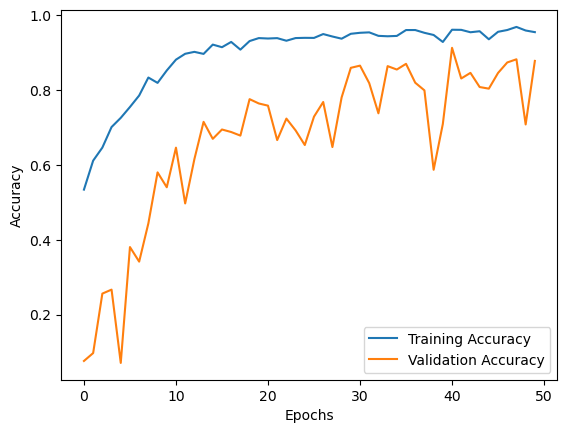

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

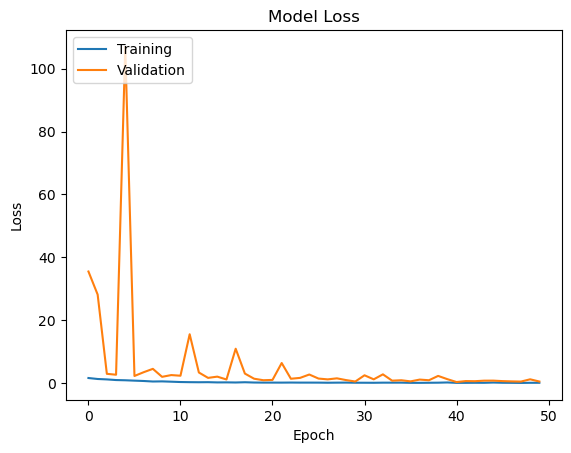

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# Predict probabilities
pred2 = model.predict(test_ds)

# Get predicted class labels
y_pred = np.argmax(pred2, axis=1)

# Extract true labels from the dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Classification report
print(classification_report(y_true, y_pred))

# Accuracy score
accuracy = accuracy_score(y_true, y_pred) * 100
print("Accuracy of the Model: {:.2f}%".format(accuracy))


144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

           0       0.05      0.05      0.05       200
           1       0.04      0.04      0.04       200
           2       0.04      0.04      0.04       200
           3       0.06      0.06      0.06       200
           4       0.02      0.01      0.02       200
           5       0.02      0.01      0.02       200
           6       0.05      0.05      0.05       200
           7       0.03      0.03      0.03       200
           8       0.03      0.03      0.03       200
           9       0.04      0.04      0.04       200
          10       0.05      0.04      0.05       200
          11       0.03      0.04      0.03       200
          12       0.05      0.06      0.06       200
          13       0.05      0.04      0.05       200
          14       0.06      0.05      0.06       200
          15       0.05      0.06      0.06       200
          16       0.02      0.03      

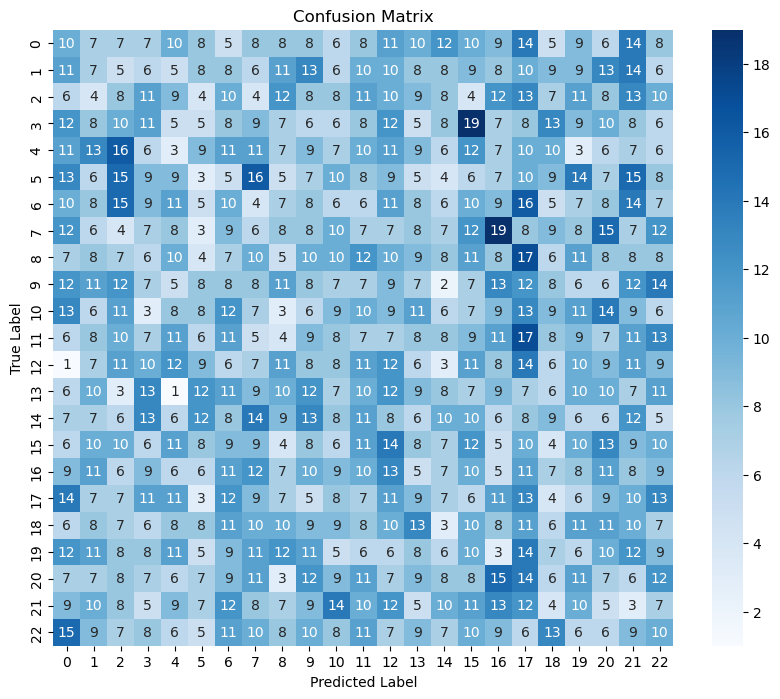

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [26]:
model.save('model/MobileNetV3Large_model.keras')
model.save('model/MobileNetV3Large.h5')